In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

1. Преобразуем в тензоры и нормализуем
======================================

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 5

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Просто показ картинок в батче


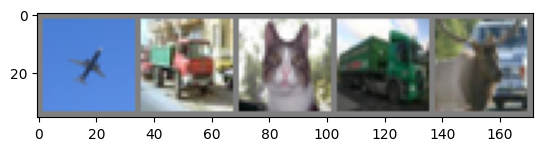

plane truck cat   truck deer 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

2. Создание модели архитектуры AlexNet
========================================

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=1, padding=1), # (64, 31, 31)
            nn.ReLU(inplace=True),
            #nn.LocalResponseNorm(alpha=1e-4, beta=0.75, k=2, size=5),
            nn.MaxPool2d(kernel_size=2), # (64, 15, 15)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 192,kernel_size=5, padding=2), # (192, 15, 15)
            nn.ReLU(inplace=True),
            #nn.LocalResponseNorm(alpha=1e-4, beta=0.75, k=2, size=5),
            nn.MaxPool2d(kernel_size=2), # (192, 7, 7) 
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),# (384,7,7)
            nn.ReLU(inplace=True),  
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(384,256, kernel_size=3, padding=1), # (256, 7, 7)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2) # (256, 3, 3)
        )

        self.fc1 = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(256*3*3, 1024),
            nn.ReLU(inplace=True),
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
        )
        self.final_linear = nn.Linear(1024, 10)


    def forward(self, out): # out -> (3, 32, 32)
        # Свёртка
        out = self.conv_block1(out) # (64, 15, 15)
        out = self.conv_block2(out) # (192, 7, 7)
        out = self.conv_block3(out) # (384,7,7)
        out = self.conv_block4(out) # (256, 3, 3)

        # Полносвязные слои
        out = out.view(out.size(0), -1)
        out = self.fc1(out) # (1024)
        out = self.fc2(out) # (1024)
        out = self.final_linear(out) # (10)
        return out

net = Net()

2.1 Модель ResNet18

In [ ]:
# class BasicBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1):
#         super(BasicBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(out_channels)
        
#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_channels != out_channels:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(out_channels)
#             )

#     def forward(self, x):
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)
#         out = self.conv2(out)
#         out = self.bn2(out)
#         out += self.shortcut(x)
#         out = self.relu(out)
#         return out

# class ResNet18(nn.Module):
#     def __init__(self, num_classes=10):
#         super(ResNet18, self).__init__()
#         self.in_channels = 64
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
#         self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
#         self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
#         self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
#         self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512, num_classes)

#     def _make_layer(self, block, out_channels, num_blocks, stride):
#         strides = [stride] + [1] * (num_blocks - 1)
#         layers = []
#         for stride in strides:
#             layers.append(block(self.in_channels, out_channels, stride))
#             self.in_channels = out_channels
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)
#         out = self.maxpool(out)
        
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
        
#         out = self.avgpool(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc(out)
#         return out
# net = ResNet18()

2.2 Пример нейросети на pytorch

In [ ]:
# import torch.nn.functional as F
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# net = Net()

3. Определим функцию ошибки и градент
=======================================

Воспользуемся кросс-энтропийной функцией ошибки и стохастическим градиентным спуском с импульсом


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Тренировка нейронной сети
====================


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        # зануляем параметры градиента
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Считаем точность и стоимость
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}: Потери: {float((running_loss - 1) / 10000)} ; Точность: {float(correct / total)}')
           # running_loss = 0.0

print('Тренировка завершена')

Epoch 1: Стоимость: 1.779 ; Точность: 0.32628
Epoch 2: Стоимость: 1.181 ; Точность: 0.57324
Epoch 3: Стоимость: 0.870 ; Точность: 0.6934
Epoch 4: Стоимость: 0.686 ; Точность: 0.76214
Epoch 5: Стоимость: 0.557 ; Точность: 0.80604
Epoch 6: Стоимость: 0.448 ; Точность: 0.84466
Epoch 7: Стоимость: 0.361 ; Точность: 0.87328
Epoch 8: Стоимость: 0.289 ; Точность: 0.89974
Epoch 9: Стоимость: 0.231 ; Точность: 0.91968
Epoch 10: Стоимость: 0.194 ; Точность: 0.93258
Epoch 11: Стоимость: 0.159 ; Точность: 0.94546
Epoch 12: Стоимость: 0.138 ; Точность: 0.9527
Epoch 13: Стоимость: 0.122 ; Точность: 0.95758
Epoch 14: Стоимость: 0.104 ; Точность: 0.9638
Epoch 15: Стоимость: 0.087 ; Точность: 0.96992
Epoch 16: Стоимость: 0.089 ; Точность: 0.97028
Epoch 17: Стоимость: 0.070 ; Точность: 0.9763
Epoch 18: Стоимость: 0.064 ; Точность: 0.97732
Epoch 19: Стоимость: 0.056 ; Точность: 0.98098
Epoch 20: Стоимость: 0.058 ; Точность: 0.98066
Epoch 21: Стоимость: 0.051 ; Точность: 0.98304
Epoch 22: Стоимость: 0.042

5. Тестируем нейронную сеть на тестовых данных
==============================================


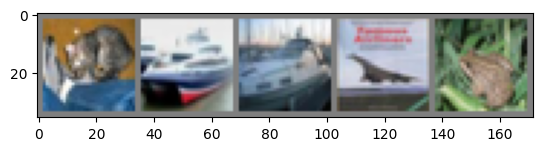

Ожидаем:  cat   ship  ship  plane frog 


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
# print images
print('Ожидаем: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

6. Получаем результаты top-1
============================

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Предполагаем: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

Предполагаем:  dog   bird  ship  truck frog 


7. Точность нейронной сети
==========================

In [ ]:
correct = 0
total = 0
with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
print(f'Точность нейронной сети на 10000 тестовых изображениях: {100 * float(correct / total):.1f}%')

Точность нейронной сети на 10000 тестовых изображениях: 81.2%


8. Точности каждого класса
==========================


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = float(correct_count) / total_pred[classname]
    print(f'Точность класса: {classname:5s} составляет {100 * accuracy:.1f}%')

Точность класса: plane составляет 87.1%
Точность класса: car   составляет 91.0%
Точность класса: bird  составляет 70.9%
Точность класса: cat   составляет 66.6%
Точность класса: deer  составляет 78.9%
Точность класса: dog   составляет 71.3%
Точность класса: frog  составляет 85.8%
Точность класса: horse составляет 86.6%
Точность класса: ship  составляет 85.4%
Точность класса: truck составляет 86.2%


In [ ]:
del dataiter